# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_PATH = Path('../data/')

## Options

In [3]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [10]:
n_models = 10
patience = 50
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [11]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [12]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 15.712s 


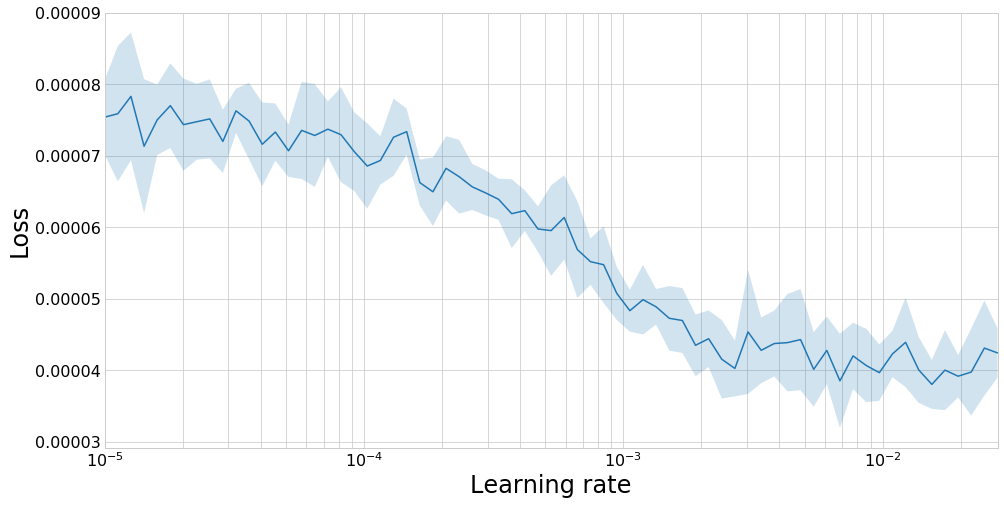

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [13]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
2 classes found, running in binary mode

1 New best found: 3.8092681836888586e-05
2 New best found: 3.460995565604574e-05
3 New best found: 3.440897196036395e-05
4 New best found: 3.403005406135591e-05
5 New best found: 3.3749118820677295e-05
7 New best found: 3.36230775922456e-05
9 New best found: 3.3577984096152746e-05
10 New best found: 3.337481775207349e-05
13 New best found: 3.307876819145618e-05
14 New best found: 3.281497483059827e-05
18 New best found: 3.2787809095468666e-05
22 New best found: 3.254782958506838e-05
30 New best found: 3.2497388268133055e-05
44 New best found: 3.243821206930781e-05
45 New best found: 3.235844796453393e-05
53 New best found: 3.235295852992279e-05
63 New best found: 3.235288354661186e-05
66 New best found: 3.2238033441518637e-05
Early stopping after 116 epochs
Score is: {'loss': 3.2238033441518637e-05, 'wAUC': 0.06531769931525455, 'AUC': 0.10011792304551015, 'AMS': 3.5898626582173008, 'cut': 0.9264234900

43 New best found: 3.1699353899703314e-05
Early stopping after 93 epochs
Score is: {'loss': 3.1699353899703314e-05, 'wAUC': 0.06320183135760893, 'AUC': 0.10461273806154969, 'AMS': 3.9241202070759154, 'cut': 0.9516626000404358}
Fold took 98.640s


______________________________________
Training finished
Cross-validation took 1071.209s 


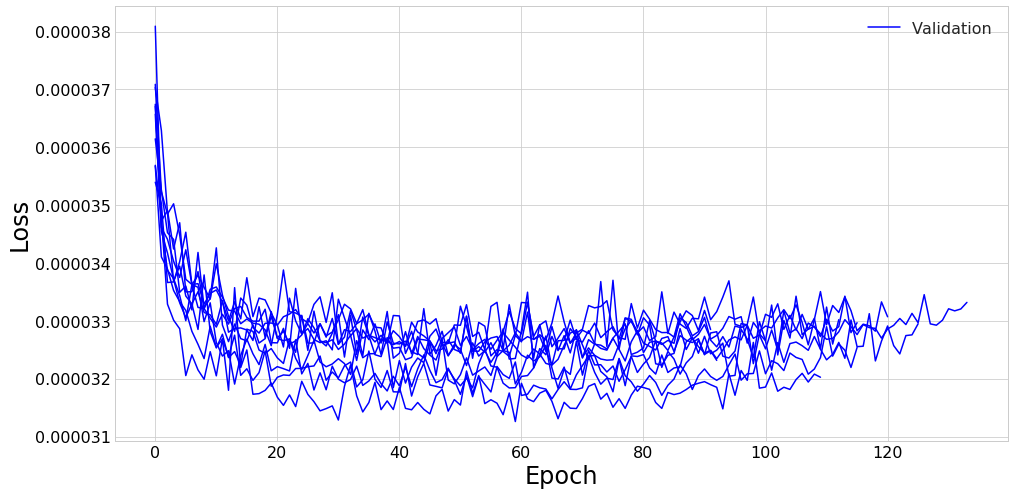

Mean loss = 3.2e-05 +- 1e-07
Mean wAUC = 0.0641 +- 0.0005
Mean AUC = 0.101 +- 0.001
Mean AMS = 3.72 +- 0.04
Mean cut = 0.952 +- 0.004
______________________________________



<Figure size 432x288 with 0 Axes>

In [14]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

The impact of data augmentation is pretty clear. Comparing the training here to that of the the CRL Swish model without augmentation we can see that we effectively gain another LR cycles worth of training epochs before we start overfitting, which allows the networks to reach much lower looses (3.18e-5 c.f. 3.23e-5) and a higher AMSs (3.98 c.f. 3.71)

## Construct ensemble

In [15]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [16]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 4 with loss = 3.1258969266491475e-05
Model 1 is 2 with loss = 3.165144303646477e-05
Model 2 is 9 with loss = 3.1699353899703314e-05
Model 3 is 7 with loss = 3.1773506978089354e-05
Model 4 is 3 with loss = 3.2186526653627785e-05
Model 5 is 8 with loss = 3.223431225778768e-05
Model 6 is 0 with loss = 3.2238033441518637e-05
Model 7 is 6 with loss = 3.2356483805051536e-05
Model 8 is 1 with loss = 3.2431679027777164e-05
Model 9 is 5 with loss = 3.243591423233738e-05


## Response on validation data

In [17]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [18]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0022166613450273873s per sample

Predicting fold 2 out of 10
Prediction took 0.00040840300638228657s per sample

Predicting fold 3 out of 10
Prediction took 0.00039905993565917015s per sample

Predicting fold 4 out of 10
Prediction took 0.0004001559659838676s per sample

Predicting fold 5 out of 10
Prediction took 0.00040216121915727853s per sample

Predicting fold 6 out of 10
Prediction took 0.00040194759480655193s per sample

Predicting fold 7 out of 10
Prediction took 0.0004007216863334179s per sample

Predicting fold 8 out of 10
Prediction took 0.00040037508141249417s per sample

Predicting fold 9 out of 10
Prediction took 0.0004001958264037967s per sample

Predicting fold 10 out of 10
Prediction took 0.00040103443823754785s per sample



In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9029557596509271, weighted 0.9359045913981765


In [20]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.9105034179734375, 0.9656147)

In [21]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9598093396052718, corresponds to calc_ams of 3.84992179532032
CPU times: user 2.59 s, sys: 16 s, total: 18.6 s
Wall time: 2min 12s


(4.0, 0.96)

# Test scoring

In [22]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [23]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00040187403415753084s per sample

Predicting fold 2 out of 10
Prediction took 0.00040145016365091907s per sample

Predicting fold 3 out of 10
Prediction took 0.00040043500240214845s per sample

Predicting fold 4 out of 10
Prediction took 0.00040280609787865117s per sample

Predicting fold 5 out of 10
Prediction took 0.00040277630864557896s per sample

Predicting fold 6 out of 10
Prediction took 0.0004014637566594915s per sample

Predicting fold 7 out of 10
Prediction took 0.00040147109475325454s per sample

Predicting fold 8 out of 10
Prediction took 0.00040140902632000773s per sample

Predicting fold 9 out of 10
Prediction took 0.0004004232057793574s per sample

Predicting fold 10 out of 10
Prediction took 0.00039960526507347823s per sample

CPU times: user 3min 55s, sys: 11.8 s, total: 4min 6s
Wall time: 3min 40s


In [24]:
score_test_data(test_fy.source, 0.9598093396052718)

Public:Private AMS: 3.6724603407531284 : 3.697501767937179


(3.6724603407531284, 3.697501767937179)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)